<a href="https://colab.research.google.com/github/TheHappyBaloney/Brewing-Perfection/blob/main/AhaCoffeeCherryBadeMazedaar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Package Import

In [1]:
import numpy as nm
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
import json

print("Import Successful!")

Import Successful!


In [2]:
# prompt: Mount dataset from google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!ls /content/drive/MyDrive/CoffeeFruitMaturity

CoffeeCherry.jpg  model.h5	Processed	    test   valid
data.yaml	  new_model.h5	README.dataset.txt  train  val_pro


In [4]:
# Set the seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Data Loading and Declarations

In [5]:
train_dir = "/content/drive/MyDrive/CoffeeFruitMaturity/train"
train_dir_img = "/content/drive/MyDrive/CoffeeFruitMaturity/train/images"
train_dir_lbl = "/content/drive/MyDrive/CoffeeFruitMaturity/train/labels"

In [6]:
img_size = 128
class_size = 5
batch_size = 32

In [7]:
def resize_and_pad(img, size):
    h, w, _ = img.shape
    scale = size / max(h, w)
    nh, nw = int(h * scale), int(w * scale)
    img_resized = cv2.resize(img, (nw, nh))

    top_pad = (size - nh) // 2
    bottom_pad = size - nh - top_pad
    left_pad = (size - nw) // 2
    right_pad = size - nw - left_pad

    img_padded = cv2.copyMakeBorder(img_resized, top_pad, bottom_pad, left_pad, right_pad, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    return img_padded

# Build a Custom Data Generator

In [8]:
def CustomDataGenerator(img_dir, lbl_dir, batch_size, datagen=None):
    image_files = os.listdir(img_dir)  # List all image files in the directory
    num_samples = len(image_files)

    while True:
        np.random.shuffle(image_files)

        for offset in range(0, num_samples, batch_size):
            batch_files = image_files[offset:offset+batch_size]
            images = []
            labels = []

            for image_file in batch_files:
                label_file = os.path.splitext(image_file)[0] + ".txt"
                label_path = os.path.join(lbl_dir, label_file)

                img_path = os.path.join(img_dir, image_file)
                img = cv2.imread(img_path)
                if img is None:
                    print(f"Image {img_path} not found.")
                    continue

                img = resize_and_pad(img, img_size)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                if os.path.exists(label_path):
                    with open(label_path, 'r') as file:
                        lines = file.readlines()

                    cherries_labels = np.zeros((class_size,), dtype=np.float32)
                    for line in lines:
                        parts = line.strip().split()
                        if len(parts) < 5:
                            continue

                        class_index = int(parts[0])
                        cherries_labels[class_index] = 1.0  # Assuming multi-label classification

                    images.append(img)
                    labels.append(cherries_labels)

            images = np.array(images)
            labels = np.array(labels)

            if datagen:
                augmented = datagen.flow(images, labels, batch_size=batch_size, shuffle=False)
                images, labels = next(augmented)
            yield images, labels

## Save and Proceed

In [9]:
def save_processed_data(data, save_dir):

    for i, (img, centroids) in enumerate(data):
        img_filename = f"image_{i}.jpg"
        json_filename = f"image_{i}.json"

        img_save_path = os.path.join(save_dir, "images", img_filename)
        json_save_path = os.path.join(save_dir, "labels",json_filename)

        cv2.imwrite(img_save_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
        with open(json_save_path, 'w') as json_file:
            json.dump(centroids, json_file)

        print(f"Processed and saved: {img_filename} and {json_filename}")

# Data Augmentation

In [10]:
# Define data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [11]:
save_dir = "/content/drive/MyDrive/CoffeeFruitMaturity/Processed"

val_dir_img = "/content/drive/MyDrive/CoffeeFruitMaturity/valid/images"
val_dir_lbl = "/content/drive/MyDrive/CoffeeFruitMaturity/valid/labels"

train_generator = CustomDataGenerator(train_dir_img, train_dir_lbl, batch_size, datagen)
val_generator = CustomDataGenerator(val_dir_img, val_dir_lbl, batch_size)


# Model Building


In [12]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')  # Assuming 5 classes for classification
])

# Adjust the learning rate if necessary
optimizer = Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Set the steps per epoch and validation steps
steps_per_epoch = len(os.listdir(train_dir_img)) // batch_size
validation_steps = len(os.listdir(val_dir_img)) // batch_size

history = model.fit(train_generator, validation_data=val_generator, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, epochs = 15)

Epoch 1/15
18/18 [==============================] - 104s 6s/step - loss: 8.6566 - accuracy: 0.5781 - val_loss: 14.2204 - val_accuracy: 0.2062
Epoch 2/15
18/18 [==============================] - 45s 3s/step - loss: 22.3080 - accuracy: 0.5704 - val_loss: 17.7351 - val_accuracy: 0.7312
Epoch 3/15
18/18 [==============================] - 39s 2s/step - loss: 46.5018 - accuracy: 0.5792 - val_loss: 22.4251 - val_accuracy: 0.7254
Epoch 4/15
18/18 [==============================] - 40s 2s/step - loss: 87.6898 - accuracy: 0.5511 - val_loss: 17.2291 - val_accuracy: 0.7042
Epoch 5/15
18/18 [==============================] - 39s 2s/step - loss: 116.8035 - accuracy: 0.5229 - val_loss: 19.2268 - val_accuracy: 0.7465
Epoch 6/15
18/18 [==============================] - 39s 2s/step - loss: 173.2018 - accuracy: 0.4894 - val_loss: 40.3641 - val_accuracy: 0.7113
Epoch 7/15
18/18 [==============================] - 39s 2s/step - loss: 221.3292 - accuracy: 0.5070 - val_loss: 56.5029 - val_accuracy: 0.7254
Epo

In [13]:
# Evaluate the model and print accuracy
train_loss, train_accuracy = model.evaluate(train_generator, steps=steps_per_epoch)
val_loss, val_accuracy = model.evaluate(val_generator, steps=validation_steps)

print(f"Training accuracy: {train_accuracy * 100:.2f}%")
print(f"Validation accuracy: {val_accuracy * 100:.2f}%")

5/5 [==============================] - 3s 619ms/step - loss: 261.2072 - accuracy: 0.6690
Training accuracy: 68.31%
Validation accuracy: 66.90%


# Test Set Introduction

In [14]:
test_dir_img = "/content/drive/MyDrive/CoffeeFruitMaturity/test/images"
test_dir_lbl = "/content/drive/MyDrive/CoffeeFruitMaturity/test/labels"

test_generator = CustomDataGenerator(test_dir_img, test_dir_lbl, batch_size)


In [15]:
# Assuming batch_size and other relevant variables are already defined

# Calculate the number of steps per epoch for the test set
test_steps = len(os.listdir(test_dir_img)) // batch_size

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_steps)

print(f"Test accuracy: {test_accuracy * 100:.2f}%")
print(f"Test loss: {test_loss}")


2/2 [==============================] - 40s 40s/step - loss: 270.8947 - accuracy: 0.6406
Test accuracy: 64.06%
Test loss: 270.8947448730469


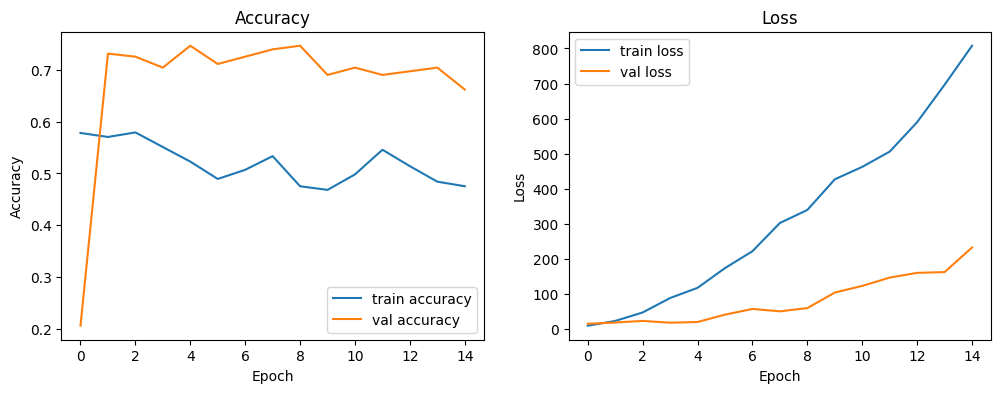

In [16]:
# Plot the accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [17]:
# Saving the model

model.save("/content/drive/MyDrive/CoffeeFruitMaturity/new_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [23]:
# Path to the saved image and JSON files
valpro_image_path = "/content/drive/MyDrive/CoffeeFruitMaturity/val_pro/images/image_1.jpg"
model_path = "/content/drive/MyDrive/CoffeeFruitMaturity/new_model.h5"
valpro_json_path = "/content/drive/MyDrive/CoffeeFruitMaturity/val_pro/labels/image_1.json"

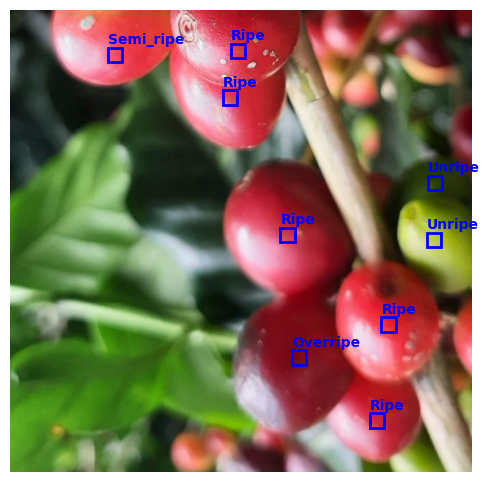

In [24]:
# Function to plot image with bounding boxes
def plot_image_with_boxes(model, image_path, json_path):
    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Image {image_path} not found.")
        return

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # image = cv2.resize(image , (1024 , 1024))

    # Read the JSON file
    with open(json_path, 'r') as file:
        all_cherries_centroids = json.load(file)

    class_labels = {
        0: "Dry",
        1: "Overripe",
        2: "Ripe",
        3: "Semi_ripe",
        4: "Unripe"
    }

    # Overlay bounding boxes on image
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.axis('off')

    for cherry in all_cherries_centroids:
        class_index = cherry['class_index']
        centroid_x = cherry['centroid_x'] * image.shape[1]
        centroid_y = cherry['centroid_y'] * image.shape[0]

        # Define bounding box parameters (adjust as needed)
        box_width = 20
        box_height = 20
        xmin = int(centroid_x - box_width / 2)
        ymin = int(centroid_y - box_height / 2)
        xmax = int(centroid_x + box_width / 2)
        ymax = int(centroid_y + box_height / 2)

        # Draw rectangle
        rect = plt.Rectangle((xmin, ymin), box_width, box_height, linewidth=2, edgecolor='blue', facecolor='none')
        plt.gca().add_patch(rect)

        # Annotate class index
        label = class_labels.get(class_index, 'Unknown')
        plt.text(xmin, ymin - 5, label, color='blue', fontsize=10, weight='bold')

    plt.show()


# Load the model
model = tf.keras.models.load_model(model_path)


# Plot the image with bounding boxes
plot_image_with_boxes(model, valpro_image_path, valpro_json_path)

2024-06-23 01:05:51.231007: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-23 01:05:51.231095: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-23 01:05:51.235252: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-23 01:05:53.518723: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
usage: tflite_convert [-h] --output_file OUTPUT_FILE
                      [--saved_model_dir SAVED_MODEL_DIR | --keras_model_file KERAS_MODEL_FILE]
                      [--saved_model_tag_set SAVED_MODEL_TAG_SET]
                      [--s

In [32]:
import tensorflow as tf

# Load the H5 model
model = tf.keras.models.load_model('/content/drive/MyDrive/CoffeeFruitMaturity/new_model.h5')

# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model to a file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model successfully converted to TFLite format.")


Model successfully converted to TFLite format.
